In [4]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

import itertools

from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.graph.edge import Edge
from autocnet.matcher.matcher import FlannMatcher
from autocnet.matcher.suppression_funcs import distance
from autocnet.utils.utils import normalize_vector

from IPython.display import display
import cv2

%pylab inline
import line_profiler
%load_ext line_profiler

ImportError: cannot import name 'normalize_vector'

## Generate a 2 image adjacenecy graph

In [2]:
#Point to the adjacency Graph
adjacency = get_path('three_image_adjacency.json')
basepath = get_path('Apollo15')
cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)

#Apply SIFT to extract features
cg.extract_features(method='sift', extractor_parameters={'nfeatures':1000})

#Match
cg.match_features()
    
#Apply outlier detection
cg.apply_func_to_edges(Edge.symmetry_check)
#cg.apply_func_to_edges(Edge.ratio_check)

#Compute a homography and apply RANSAC
cg.apply_func_to_edges("compute_fundamental_matrix", clean_keys=['symmetry'])
cg.apply_func_to_edges("suppress", clean_keys=['fundamental'], suppression_func=distance, k=100)

/Users/jlaura/github/autocnet/autocnet/matcher/outlier_detector.py:261: UserWarning: Unable to optimally solve.  Returning with 111 points
  warnings.warn('Unable to optimally solve.  Returning with {} points'.format(len(result)))


In [3]:
cg[1][2].plot(clean_keys=['suppression'], line_kwargs={'linewidth':0})
show()
cg[0][1].plot(clean_keys=['suppression'], line_kwargs={'linewidth':0})
show()
cg[0][2].plot(clean_keys=['suppression'], line_kwargs={'linewidth':0})

NameError: name 'show' is not defined

In [4]:
cg.compute_triangular_cycles()

[(0, 1, 2)]

In [19]:
x = set([1,2,3])
x.difference(set([2]))

{1, 3}

In [9]:
list(itertools.combinations(*cg.compute_triangular_cycles(), 2))

[(0, 1), (0, 2), (1, 2)]

<bound method Graph.edges of <autocnet.graph.network.CandidateGraph object at 0x11f6838d0>>

In [47]:
def d(a,b, threshold):
    e2 = cg[a[0]][a[1]]
    e = cg.edge[b[0]][b[1]]

    F = e.fundamental_matrix
    match_idx = e2.matches[e2.fundamental_matrix.mask]

    x = e2.source.get_keypoint_coordinates(index=match_idx['source_idx'], homogeneous=True)
    x1 = e.destination.get_keypoint_coordinates(homogeneous=True)
    
    #Normalize the vector
    l_norm = normalize_vector(x.dot(F.T))
    for i, (j, row) in enumerate(x.iterrows()):
        source_descriptor = e.source.descriptors[j]
        epipolar_line = l_norm[i]    
        dist = np.abs(epipolar_line.dot(x1.T))
        candidates = dist.argsort()
        # Plot the base
        flag_distance = math.inf
        match = None
        for c in candidates:
            if dist[c] < threshold:
                didx = x1.loc[c]

                destination_descriptor = e.destination.descriptors[didx.name]
                descriptor_distance = cv2.norm(source_descriptor, destination_descriptor, cv2.NORM_L2)
                if descriptor_distance < flag_distance:
                    flag_distance = descriptor_distance
                    match = didx
    return




def deepen(nodes, threshold=4):
    subset_nodes = set(nodes)
    for n in nodes:
        sn = set([n])
        o = list(subset_nodes.difference(sn))
        
        a = (n, o[0])
        b = (n, o[1])

        d(a, b, threshold)
        d(b, a, threshold)
        
        
import time
t1 = time.time()

%lprun deepen(cg.compute_triangular_cycles()[0])
t2 = time.time()
print(t2 - t1)

9.202957153320312e-05


ERROR: Line magic function `%lprun` not found.


/Users/jlaura/github/autocnet/autocnet/graph/node.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  keypoints['homogeneous'] = 1


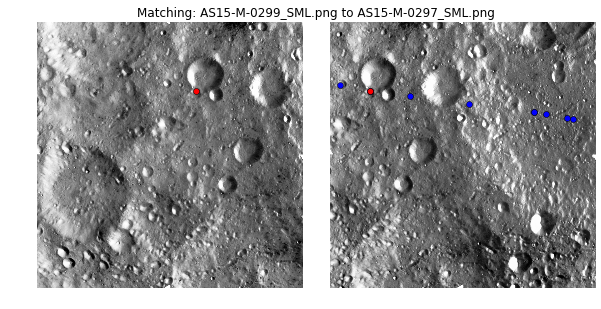

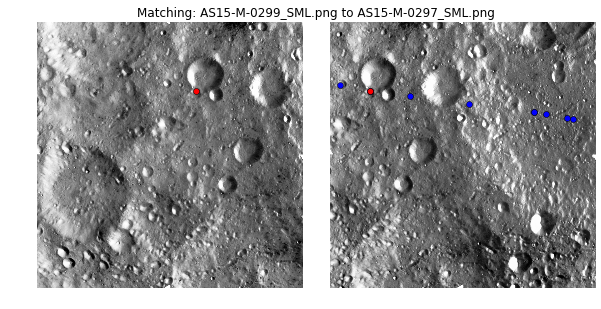

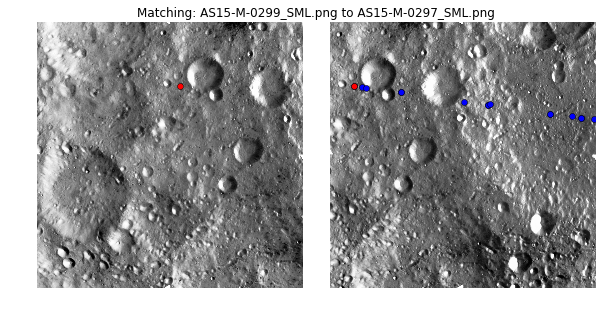

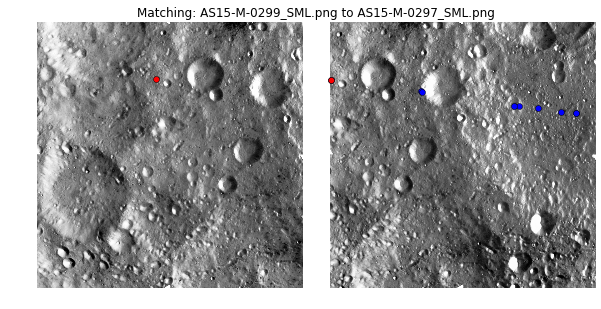

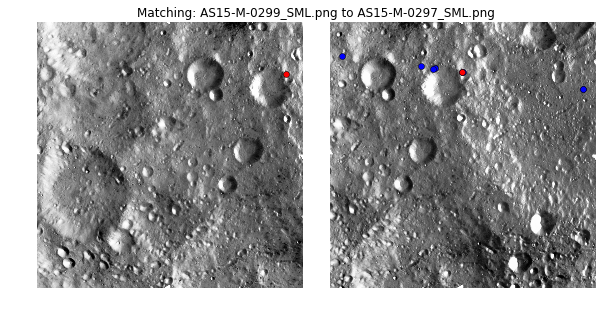

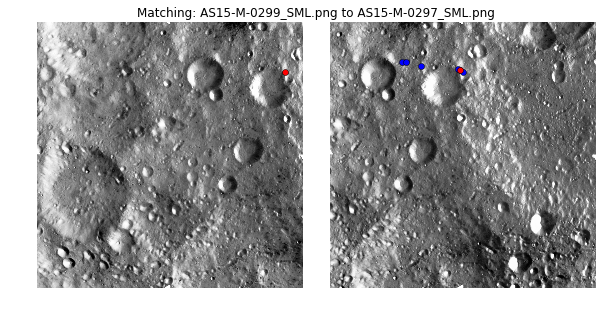

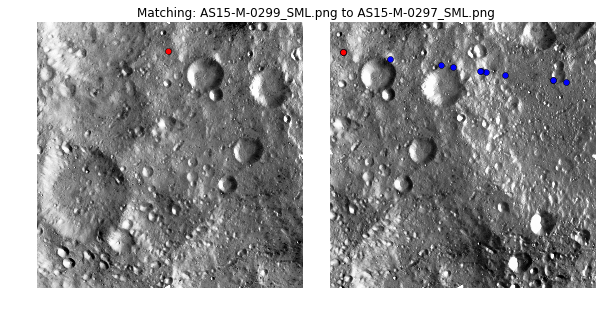

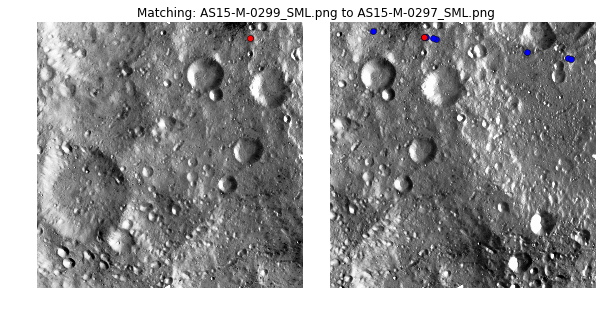

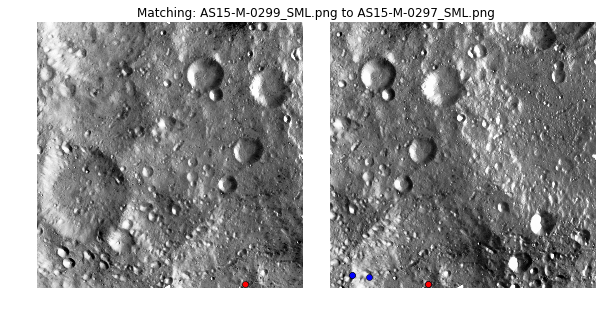

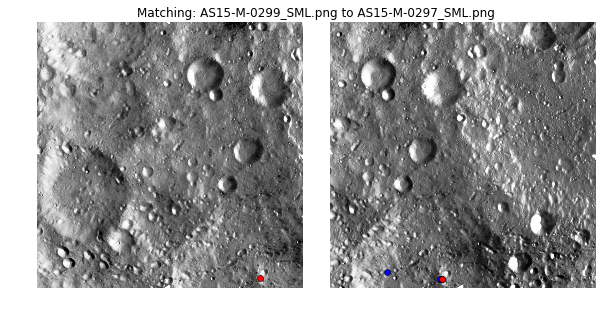

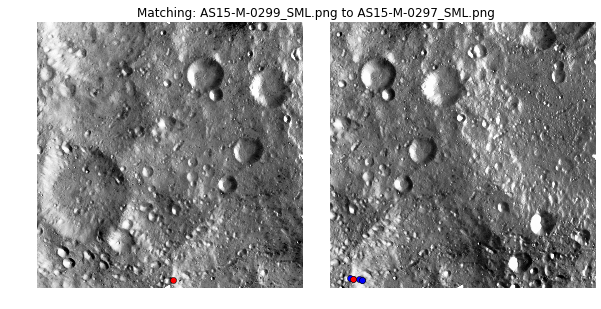

In [160]:
figsize(10,10)
import pandas as pd
from scipy.spatial.distance import hamming


THRESHOLD = 4

e = cg[0][1]
F = e.fundamental_matrix
match_idx = e.matches[F.mask]
x = e.source.get_keypoint_coordinates(index=match_idx['source_idx'], homogeneous=True)
x1 = e.destination.get_keypoint_coordinates(homogeneous=True)

def show_base(edge, ax=None, image_space=100, scatter_kwargs={},
             line_kwargs={}, image_kwargs={}):
    if ax is None:
        ax = plt.gca()

    # Plot setup
    ax.set_title('Matching: {} to {}'.format(edge.source.image_name,
                                             edge.destination.image_name))
    ax.margins(tight=True)
    ax.axis('off')

    # Image plotting
    source_array = edge.source.get_array()
    destination_array = edge.destination.get_array()

    s_shape = source_array.shape
    d_shape = destination_array.shape

    y = max(s_shape[0], d_shape[0])
    x = s_shape[1] + d_shape[1] + image_space
    composite = np.zeros((y, x))

    composite[:, :s_shape[1]] = source_array
    composite[:, s_shape[1] + image_space:] = destination_array

    if 'cmap' in image_kwargs:
        cmap = image_kwargs['cmap']
    else:
        cmap = 'Greys'

    ax.imshow(composite, cmap=cmap)

"""
Normalization allows for the dot product of a 
point to the normalized line returns the distance.
"""
def normalize_vector(line):
    """
    Normalize the vector.
    """
    if isinstance(line, pd.DataFrame):
        line = line.values
    n = np.sqrt(line[:,0]**2 + line[:,1]**2).reshape(-1,1)
    line /= n
    return line

#Normalize the vector
l_norm = normalize_vector(x.dot(F.T))
for i, (j, row) in enumerate(x.iterrows()):
    source_descriptor = e.source.descriptors[j]
    epipolar_line = l_norm[i]    
    dist = np.abs(epipolar_line.dot(x1.T))
    candidates = dist.argsort()
    # Plot the base
    show_base(e)
    plot(row['x'], row['y'], 'ro')
    flag_distance = math.inf
    match = None
    for c in candidates:
        if dist[c] < THRESHOLD:
            didx = x1.loc[c]
            
            destination_descriptor = e.destination.descriptors[didx.name]
            descriptor_distance = cv2.norm(source_descriptor, destination_descriptor, cv2.NORM_L2)
            plot(didx['x']+ 100 + 1012, didx['y'], 'bo')
            if descriptor_distance < flag_distance:
                flag_distance = descriptor_distance
                match = didx
    try:
        plot(match['x'] + 100 + 1012, match['y'], 'ro')
    except:pass
    show()
    if i == 10:
        break


As above, except, try rto use the fundamental matrix from edge `[0][2]` to increase depth on `[0][1]`.

538.5257654003195
536.1501655320084
625.445441265663
471.8495522939489
614.5958021334021
575.2573337211791
521.0988389931415
561.6199782771265
451.3269325001556
548.9790524236786


/Users/jlaura/github/autocnet/autocnet/graph/node.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  keypoints['homogeneous'] = 1


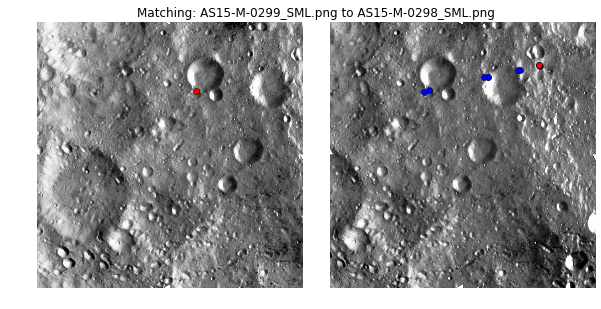

523.5828492225467
79.12016177940993
477.32483698211223
529.4667128347164
591.6037525235959
548.6219098796547
471.9120680804847
503.04671751239965
466.90791383312404
520.7446591180749


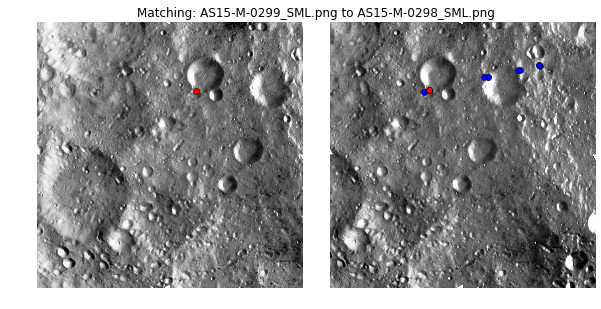

84.16650165000326
562.1441096373776
272.6554602424092
404.9617265865998
429.6335647967928
352.69391829176755
327.66904034406423
267.46962444359923


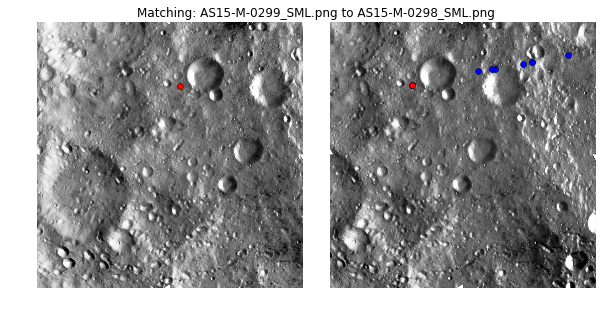

52.592775169218825
609.5055373005237
469.8584893348209


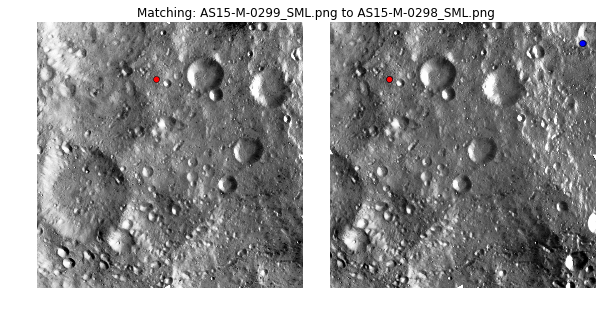

439.117296402681
467.43234804621727
512.5260968965385
439.9363590338948
515.4541686706976
415.4286942424656


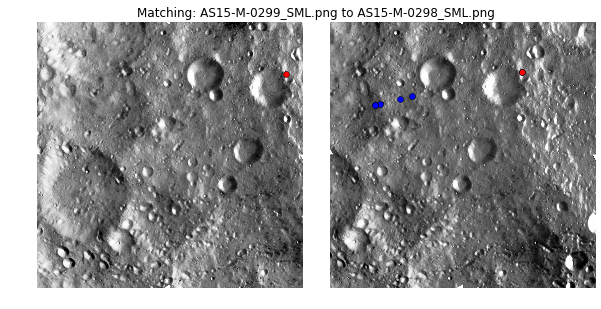

110.59385154700057
535.4969654442498
583.0240132275857
521.9856319861688
493.61827356774387
586.170623624214
474.31002519449237
505.560085449791
489.9367306091675
553.7111160162851


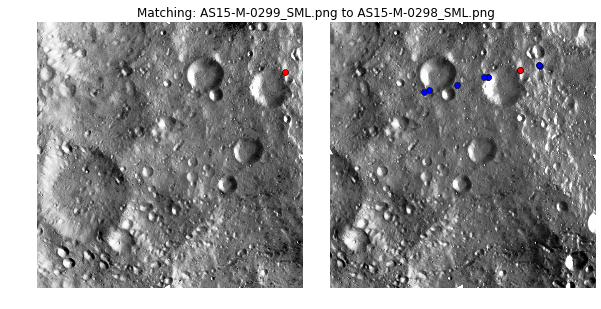

404.2091043012267
458.8550969532757
53.95368384086484
549.0218574883882
492.03353544245334


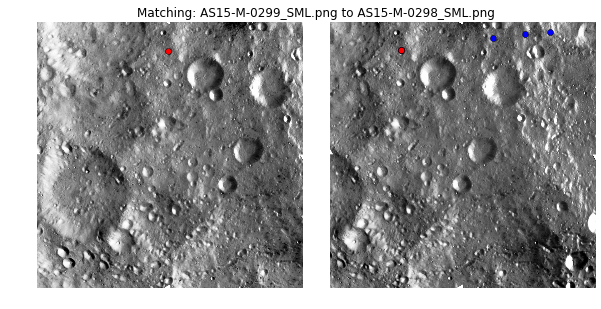

566.505074999333
481.43535391576717
354.7407504079564
398.7931794802915
79.00632886041473
495.00808074212284


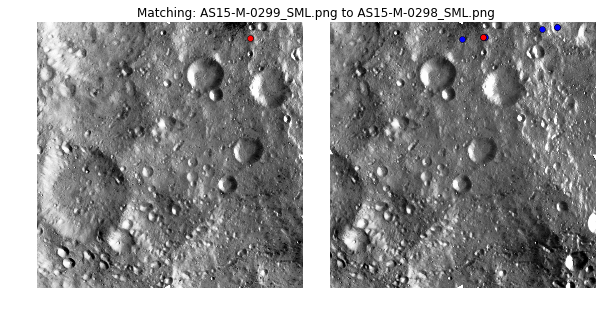

604.6924838295909
389.5831105168703
391.8634966413687
398.62262855989496


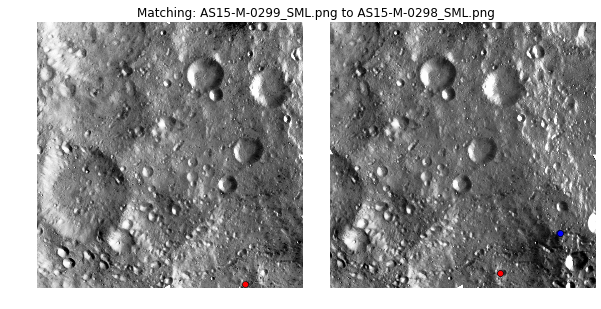

91.25239722878517
561.694756963246
581.6433615197546
610.1647318552589
573.7604029557982
615.2706721435696
441.8167040753439


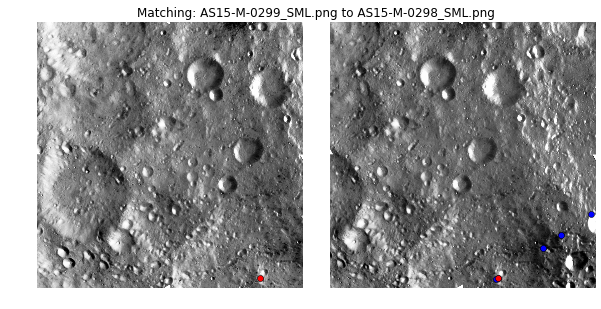

580.7383231714607
478.7410573577328
492.00711376970963
486.5449619511027
128.51848116127113
486.7340136049668


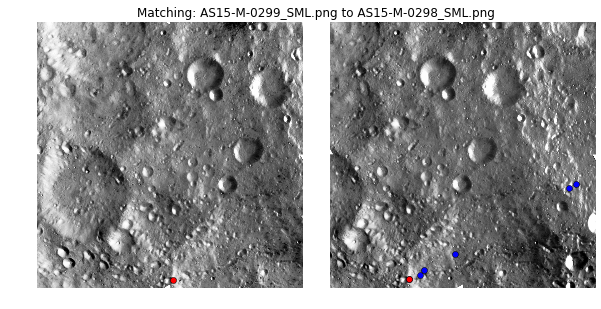

In [164]:
THRESHOLD = 4

e2 = cg[0][1]
e = cg[0][2]
F = e.fundamental_matrix
match_idx = e2.matches[e2.fundamental_matrix.mask]



x = e2.source.get_keypoint_coordinates(index=match_idx['source_idx'], homogeneous=True)
x1 = e.destination.get_keypoint_coordinates(homogeneous=True)

def show_base(edge, ax=None, image_space=100, scatter_kwargs={},
             line_kwargs={}, image_kwargs={}):
    if ax is None:
        ax = plt.gca()

    # Plot setup
    ax.set_title('Matching: {} to {}'.format(edge.source.image_name,
                                             edge.destination.image_name))
    ax.margins(tight=True)
    ax.axis('off')

    # Image plotting
    source_array = edge.source.get_array()
    destination_array = edge.destination.get_array()

    s_shape = source_array.shape
    d_shape = destination_array.shape

    y = max(s_shape[0], d_shape[0])
    x = s_shape[1] + d_shape[1] + image_space
    composite = np.zeros((y, x))

    composite[:, :s_shape[1]] = source_array
    composite[:, s_shape[1] + image_space:] = destination_array

    if 'cmap' in image_kwargs:
        cmap = image_kwargs['cmap']
    else:
        cmap = 'Greys'

    ax.imshow(composite, cmap=cmap)

"""
Normalization allows for the dot product of a 
point to the normalized line returns the distance.
"""
def normalize_vector(line):
    """
    Normalize the vector.
    """
    if isinstance(line, pd.DataFrame):
        line = line.values
    n = np.sqrt(line[:,0]**2 + line[:,1]**2).reshape(-1,1)
    line /= n
    return line

#Normalize the vector
l_norm = normalize_vector(x.dot(F.T))
for i, (j, row) in enumerate(x.iterrows()):
    source_descriptor = e.source.descriptors[j]
    epipolar_line = l_norm[i]    
    dist = np.abs(epipolar_line.dot(x1.T))
    candidates = dist.argsort()
    # Plot the base
    show_base(e)
    plot(row['x'], row['y'], 'ro')
    flag_distance = math.inf
    match = None
    for c in candidates:
        if dist[c] < THRESHOLD:
            didx = x1.loc[c]
            
            destination_descriptor = e.destination.descriptors[didx.name]
            descriptor_distance = cv2.norm(source_descriptor, destination_descriptor, cv2.NORM_L2)
            print(des)
            plot(didx['x']+ 100 + 1012, didx['y'], 'bo')
            if descriptor_distance < flag_distance:
                flag_distance = descriptor_distance
                match = didx
    try:
        plot(match['x'] + 100 + 1012, match['y'], 'ro')
    except:pass
    show()
    if i == 10:
        break

In [8]:
import networkx as nx

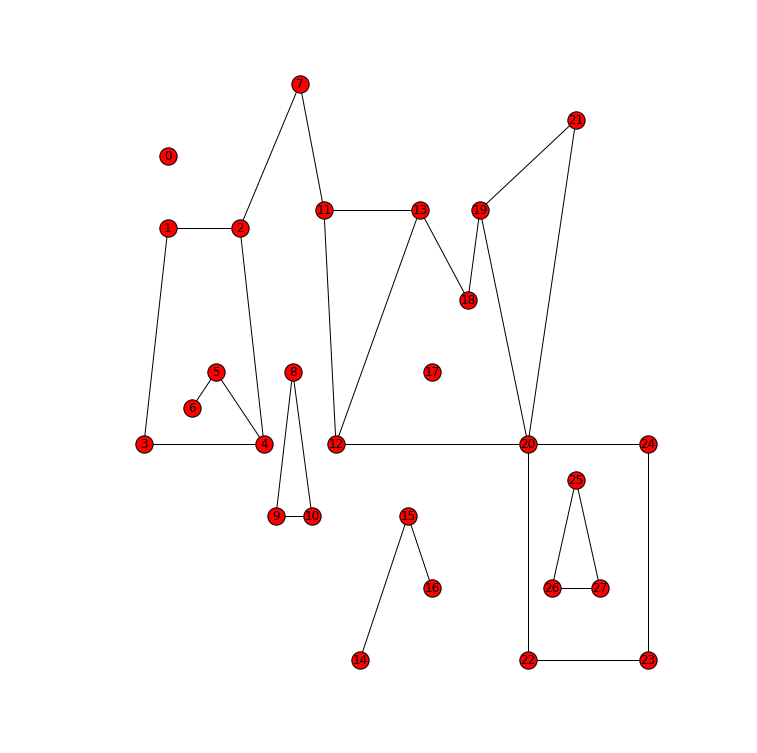

In [177]:
# from eberly http://www.geometrictools.com/Documentation/MinimalCycleBasis.pdf
coords = {}
coords[0] = 1,8
coords[1] = 1,7
coords[2] = 4,7
coords[3] = 0,4
coords[4] = 5,4
coords[5] = 3,5
coords[6] = 2, 4.5
coords[7] = 6.5, 9
coords[8] = 6.2, 5
coords[9] = 5.5,3
coords[10] = 7,3
coords[11] = 7.5, 7.25
coords[12] = 8,4
coords[13] = 11.5, 7.25
coords[14] = 9, 1
coords[15] = 11, 3
coords[16] = 12, 2
coords[17] = 12, 5
coords[18] = 13.5, 6
coords[19] = 14, 7.25
coords[20] = 16, 4
coords[21] = 18, 8.5
coords[22] = 16, 1
coords[23] = 21, 1
coords[24] = 21, 4
coords[25] = 18, 3.5
coords[26] = 17, 2
coords[27] = 19, 2


vertices = {}
for v in range(28):
    vertices[v] = []
    
vertices[1] = [2,3]
vertices[2] = [1,4,7]
vertices[3] = [1,4]
vertices[4] = [2,3,5]
vertices[5] = [4,6]
vertices[6] = [5]
vertices[7] = [2,11]
vertices[8] = [9,10]
vertices[9] = [8,10]
vertices[10] = [8,9]
vertices[11] = [7,12,13]
vertices[12] = [11,13,20]
vertices[13] = [11,12,18]
vertices[14] = [15]
vertices[15] = [14, 16]
vertices[16] = [15]
vertices[18] = [13,19]
vertices[19] = [18,20,21]
vertices[20] = [12,19,21,22,24]
vertices[21] = [19,20]
vertices[22] = [20,23]
vertices[23] = [22,24]
vertices[24] = [20,23]
vertices[25] = [26,27]
vertices[26] = [25,27]
vertices[27] = [25,26]

eberly = vertices.copy()

eg = nx.Graph(vertices)
g = nx.Graph(vertices)
nx.draw(g, coords, with_labels=True)

In [179]:
print([i for i in nx.cycle_basis(g) if len(i) == 3])

[[12, 13, 11], [20, 21, 19], [9, 10, 8], [26, 27, 25]]


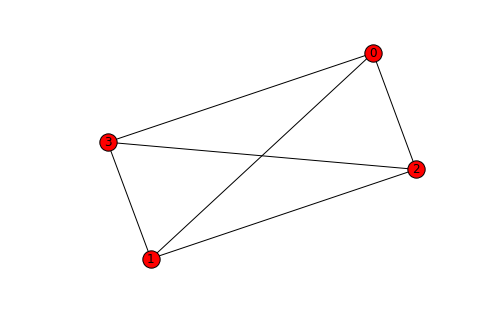

In [9]:
g = nx.Graph()
g.add_edges_from([(0,1), (0,2), (1,2), (0,3), (1,3), (2,3)])
nx.draw(g, with_labels=True)

0 1 2
0 1 3
0 2 3
1 2 3


In [201]:
nx.find_cycle(g)

[(0, 1), (1, 2), (2, 0)]

In [ ]:
from scipy.optimize import leastsq

e = cg[0][1]
H = e.homography
print(H)

s_pts = e.source.get_keypoint_coordinates(index=e.matches['source_idx'], homogeneous=True).values
d_pts = e.destination.get_keypoint_coordinates(index=e.matches['destination_idx'], homogeneous=True).values

#Cost Function
def f(H, ):
    pass

In [ ]:
cg[1][2].plot(clean_keys=['ransac'], line_kwargs={'linewidth':0})
show()
cg[0][1].plot(clean_keys=['ransac'], line_kwargs={'linewidth':0})
show()
cg[0][2].plot(clean_keys=['ransac'], line_kwargs={'linewidth':0})

Refinement should not look at the point to line distance, but at the error in the theoretical best, 0.

In [ ]:
e = cg[0][1]
F = e.fundamental_matrix

f_matches = e.matches[F.mask]
sc = e.source.get_keypoints().loc[f_matches['source_idx']][['x', 'y']]
dc = e.destination.get_keypoints().loc[f_matches['destination_idx']][['x', 'y']]
all_dc = e.destination.get_keypoints()[['x', 'y']]

sc_h = np.ones((len(sc), 3))
sc_h[:,:2] = sc

dc_h = np.ones((len(dc), 3))
dc_h[:,:2] = dc

for j, (i, m) in enumerate(f_matches.iterrows()):
    print(sc_h[j].T.dot(F).dot(dc_h[j]))
    print(m['source_idx'])

v = np.empty(len(dc_h))
for i, r in enumerate(dc_h):
    v[i] = sc_h[0].T.dot(F).dot(r)
print(sc)
print(min(abs(v)), np.argmin(abs(v)))
print(sc.iloc[0], dc.iloc[120])
print(f_matches[f_matches['source_idx'] == 265])

In [ ]:
cg.to_cnet(clean_keys=['suppress'])

### The graph object:
The underlying data structure is a graph, where each node is an image and each edge is the connectivity between nodes.  Nodes and Edges are classes with associated attributes and methods.  This notebook primarily focuses on the plotting functionality on the graph (and graph components).

In these notebooks, the graph object is being stored in the variable `cg`.  Access to nodes and edges is positional.

  * To access a node in the graph:  `cg[node_idx]`, e.g. `cg[0]`.
  * To access an edge in the graph: `cg[source_idx][destination_idx]`, e.g. `cg[0][1]`
  

## Plot the graph

In [ ]:
cg.plot()

## Plot features at an individual node, e.g. a single image

All defaults are used here.

In [ ]:
cg.node[1].plot()

This example specifies a plotting layout, passing in an axis object and passes along a color.  All the MatPlotLib plotting arguments are supported.

In [ ]:
ax1 = plt.subplot(1,1,1)
ax = cg.node[0].plot(ax=ax1, color='y')

## Plotting Matches on an Edge
The plotting capability on a given node is limited to a single image; one can envision the node as being the image with all associated metadata and derived information.  The edge represents the overlap between images and resultant shared information, e.g. point correspondences, a homography, etc.

#### Plot the matches between an edge using two outlier detector masks
To get a rough idea of what a 'good' results should be, we should see no, or few, lines which intersect.

In [ ]:
fig, ax = plt.subplots(1,1)
ax = cg.edge[0][1].plot(clean_keys=['ratio', 'symmetry', 'fundamental'], ax=ax)

#### Now plot with the added, ransac computed mask

In [ ]:
cg.edge[0][1].plot(clean_keys=['ratio', 'symmetry', 'fundamental'], line_kwargs={'linewidth':0})

## Compute Coverage Metric
We compute a coverage metric by utilizing the homography to project the destination image corner pixel coordinates into the source image and computing the intersection.  This is a rough estimate that is as good (or poor) as the homography.

In [ ]:
H = cg.edge[0][1].homography
print('Not zero is good:', H.determinant)
print('Not huge is good: ', H.condition)
print('Shifts less than one pixel in all directions are good:', H.rmse)

In [ ]:
#Ideal coverage would be 1.0
cg.edge[0][1].coverage_ratio(clean_keys=['ransac'])

The above suggests that the quality is a function of the homography.  Just how good is the homography?  We can use the determinant (something near 1 is bad), the condition (a very large number, e.g. $10^15$ is bad), or the RMSE (reported in the x and y directions).

## Viewing Keypoint Information
Here we want to explore the attributes of the keypoints, using the masking information, e.g. the outlier detection methods.  The question is, what are the characteristics of those keypoints that have made it through the outlier detection.

In [ ]:
skp, dkp = cg.edge[0][1].keypoints(clean_keys=['ratio', 'symmetry', 'ransac'])
display(skp)
display(dkp)

## Subpixel Register
We suggest only subpixel registering 'good' candidate matches as the subpixel registration process can be time consuming.

In [ ]:
cg.edge[0][1].subpixel_register(clean_keys=['fundamental', 'symmetry', 'ratio'],template_size=5, search_size=15)

In [ ]:
cg.edge[0][1].plot(clean_keys=['ratio', 'symmetry', 'fundamental', 'subpixel'])

In [ ]:
cg.edge[0][1].plot(clean_keys=['ratio', 'symmetry', 'fundamental', 'subpixel'], line_kwargs={'linewidth':0})

## Apply Suppression vis Disk Covering
This method seeks to keep the $k$ strongest correlations with a good spatial distribution.

In [ ]:
cg.edge[0][1].suppress(k=100)

# Plot, in blue the points that passed all outlier detectors so far
cg.edge[0][1].plot(clean_keys=['ratio', 'symmetry', 'fundamental', 'subpixel'], line_kwargs={'linewidth':0})
# Overlay, in red, the points that remain after suppression
cg.edge[0][1].plot(clean_keys=['suppression'], line_kwargs={'linewidth':0}, scatter_kwargs={'color':'red'})